# Computer Vision Problem

Computer vision is a core component of our perception pipeline. This a basic question that asks you to manipulate ResNet-50 trained on ImageNet. 

**Note:** This question requires GPU acceleration. It should be run in Colab with: 

Runtime > Change Runtime type > Hardware accelerator > Gpu

In [0]:
from matplotlib import pyplot as plt
import torch
from tqdm import tqdm_notebook as tqdm
import numpy as np
import torchvision.models as models
import cv2
import torchvision.transforms as transforms
cuda_available = torch.cuda.is_available()

In [0]:
import requests
def download(url, fn=None):
  if fn is None:
    fn = url.split('/')[-1]
  r = requests.get(url)
  if r.status_code == 200:
      open(fn, 'wb').write(r.content)
      print("{} downloaded: {:.2f} KB".format(fn, len(r.content)/1024.))
  else:
      print("url not found:", url)

Download the test image and models

In [3]:
download('http://6.869.csail.mit.edu/fa19/psets19/pset6/imagenet_classes.txt')
download('http://6.869.csail.mit.edu/fa19/psets19/pset6/WelshCorgi.jpeg')

arch = 'resnet50'
model = models.__dict__[arch](pretrained=True)
model.eval();
model.cuda();


imagenet_classes.txt downloaded: 21.17 KB
WelshCorgi.jpeg downloaded: 127.39 KB


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth




## Load imagenet class names





In [4]:
with open('imagenet_classes.txt', 'r') as f:
  imagenet_classes = f.readlines()
  imagenet_classes_short = [x.strip().split(',')[-1] for x in imagenet_classes]
 
print('Imagenet classes')
for it, class_name in enumerate(imagenet_classes):
  if it == 3:
    print('...')
  elif it < 4 or it > 997:
    print('{}. {}'.format(it, class_name))

Imagenet classes
0. tench, Tinca tinca

1. goldfish, Carassius auratus

2. great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias

...
998. ear, spike, capitulum

999. toilet tissue, toilet paper, bathroom tissue


## Prepare the image




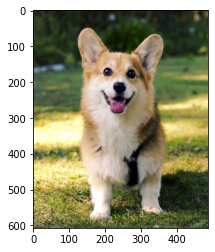

In [5]:
# Load the image we will be playing with
img = cv2.imread('WelshCorgi.jpeg')
plt.imshow(img[:, :, ::-1])


In [0]:
# In order to run the image through a model. We need to prepare it first
# This includes:
# 1. Resizing the image to an appropiate size for the network
# 2. Convert the image to a tensor - this will set the image in the 0-1 range
#    and change the channel/dimensions order
# 3. Normalize the image
# 4. Put the image in a batch. In our case we will use a single element batch.

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

def prepare_image(image_cv2, do_normalize=True):
  # Resize
  img = cv2.resize(image_cv2, (224, 224))
  img = img[:, :, ::-1].copy()
  # Convert to tensor
  tensor_img = transforms.functional.to_tensor(img)
  
  # Possibly normalize
  if do_normalize:
    tensor_img = normalize(tensor_img)
  # Put image in a batch
  batch_tensor_img = torch.unsqueeze(tensor_img, 0)
  
  # Put the image in the gpu
  if cuda_available:
    batch_tensor_img = batch_tensor_img.cuda()
  return batch_tensor_img


def UnNormalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]):
  std_arr = torch.tensor(std)[:, None, None]
  mean_arr = torch.tensor(mean)[:, None, None]
  def func(img):
    img = img.clone()
    img *= std_arr
    img += mean_arr
    return img
  return func
unnormalize = UnNormalize()

def obtain_image(tensor_img, do_normalize=True):
  tensor_img = tensor_img.cpu()
  if do_normalize:
    tensor_img = unnormalize(tensor_img)
  img = transforms.functional.to_pil_image((tensor_img.data))
  return img
  


## Run the network

In [0]:
# Prepare the image
batch_normalized_img = prepare_image(img)
# Run it through the network
output = model(batch_normalized_img)

Visualize the top classes

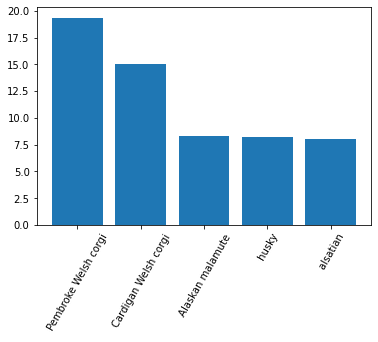

In [8]:
def plot_top_classes(values, top_k=5):
  sorted_classes = np.argsort(-values)
  class_ids = sorted_classes[:top_k]
  class_names = [imagenet_classes_short[it] for it in list(class_ids)]
  class_values = values[class_ids]
  plt.bar(class_names, class_values)
  plt.xticks(rotation=60)


plot_top_classes(output[0,:].data.cpu().numpy())

This should show the model successfully identify the image as a Corgi. : )


# The Problem

Correctly identifying images with pre-trained nets is useful, but generating adversarial cases demonstrates a slight deeper knowledge of ML techniques.

The goal is produce an adversarial image from `WelshCorgi.jpeg` which maxmizes the imagenet class 76, Tarantula. 

We will do this by using backpropagation to obtain the gradient of loss with respect to this image, given the network parameters. We will then update the image to minimize the loss with respect to ImageNet class 76, Tarantula. 

This will generate a new adversarial image which maximizes the prediction of this class. 



### Step Class

We will use the following class to generate our image. This class will take a tensor x corresponding to the image and g corresponding to the gradient and will update x according to g. To ensure that the updated image lies in a reasonable manifold, we will also allow for a projection.

**You don't need to read or change any of the code in this class.**


In [0]:
class StepImage():
  def __init__(self, orig_input, step_size=2, is_normalized=True, 
               renorm=True, eps=30, norm_update='l2'):
    self.orig_input = orig_input
    if is_normalized:
      mean=[0.485, 0.456, 0.406]
      std= [0.229, 0.224, 0.225]
    else:
      mean=[0., 0., 0.]
      std= [1., 1., 1.]
    
    is_cuda = orig_input.is_cuda
    self.mean = torch.tensor(mean)[:, None, None]
    self.std = torch.tensor(std)[:, None, None]
    if is_cuda:
      self.mean = self.mean.cuda()
      self.std = self.std.cuda()
    self.eps = eps
    self.renorm = renorm
    self.step_size = step_size
    self.norm_update = norm_update
    
  def project(self, x):
    """
    """
    diff = x - self.orig_input
    if self.renorm:
      diff = diff.renorm(p=2, dim=0, maxnorm=self.eps)
    val_projected = self.orig_input + diff
    
    val_projected *= self.std
    val_projected += self.mean
    val_clamped = torch.clamp(val_projected, 0, 1)
    val_clamped -= self.mean
    val_clamped /= self.std
    return val_clamped
  
  def step(self, x, g):
    step_size = self.step_size
    # Scale g so that each element of the batch is at least norm 1
    if self.norm_update == 'l2':
      l = len(x.shape) - 1
      g_norm = torch.norm(g.view(g.shape[0], -1), dim=1).view(-1, *([1]*l))
    else:
      g_norm = torch.torch.abs(g).mean()
    scaled_g = g / (g_norm + 1e-10)
    stepped = x + scaled_g * step_size
    projected = self.project(stepped)
    return projected

## Putting it all together

Okay, after all too much set up we will ask you to write 3 lines of code. 
1. Find the output of the model on the batch_tensor representation of the image.
2. Create an objective which maximizes ImageNet class 76.
3. Compute the gradient of the objective with respect to the batch_tensor.

Good luck!


In [11]:
img = cv2.imread('WelshCorgi.jpeg')
starting_image = prepare_image(img)

# This allows to backpropagate the image
batch_tensor = starting_image.clone().requires_grad_(True)

# This updates the image according to some gradient
step = StepImage(starting_image, step_size=0.05, 
                 is_normalized=True, renorm=False, norm_update='abs')

for _ in tqdm(range(100)):
  # YOUR CODE GOES HERE. You should:
  # 1. Run the model with batch_tensor
  output = model(batch_tensor)
  
  # 2. Describe the loss or the objective you want to maximize
  objective = torch.nn.functional.log_softmax(output, 1)[0, 76]
  
  # 3. Compute the gradient of the objective with respect to the image
  # using torch.autograd.grad
  gradient, = torch.autograd.grad(objective, batch_tensor)

  # Update the batch tensor with a gradient step
  batch_tensor = step.step(batch_tensor, gradient)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


# Show the result

This should show a somewhat distorted version of `WelshCorgi.jpeg`.


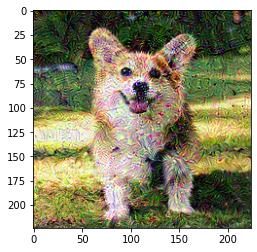

In [12]:
image = obtain_image(batch_tensor[0, :], do_normalize=True)
plt.imshow(image)

This should show a ~1.0 probability of the tarantula class.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  


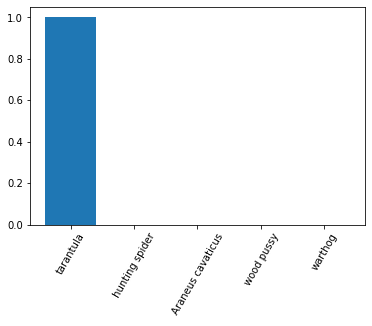

In [19]:
output = model(batch_tensor.cuda())
output_probs = torch.exp(torch.nn.functional.log_softmax(output))
plot_top_classes(output_probs[0,:].data.cpu().numpy())